# Multisensor rail detection in automatic train operations - Exploratory data analysis for RailSem19 dataset

Attila Kovacs
25.9.2023

## Introduction

In this notebook, we will perform the exploratory data analysis for the RailSam19 dataset by the Austrian Institute of Technology GmbH (wilddash.cc/railsem19).
The goal is to get a deep understanding of the characteristics of the datasets and how it can be best applied to solve the rail detection problem.



## Requiered packages

In [1]:
#from config import settings
import os
from glob import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import re
import cv2
from easyimages import EasyImage, EasyImageList, bbox
from easyimages.easyimages import CTX

from utils import print_image, parse_rail_sem_input, print_map, calculate_brightness

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline


## Load metadata

In [2]:
path = "./orig_data/rs19_val/jsons/rs19_val/"
df = parse_rail_sem_input(path)

An example of the dataframe including the used columns is given below.

In [3]:
df.columns

Index(['path', 'width', 'height', 'type', 'label_uid', 'val', 'closed'], dtype='object')

* path: path to image
* height: height of image
* width: width of image
* type: object type or class
* label_uid: ID of label or annotation
* closed: whether or not polyline is closed
* val: value of polyline


In [4]:
df.head()

,path,width,height,type,label_uid,val,closed
0,rs00000.jpg,1920,1080,rail,0,"[[1165, 1075], [1163, 1069], [1160, 1063], [11...",False
1,rs00000.jpg,1920,1080,rail,1,"[[901, 1079], [902, 1073], [902, 1066], [903, ...",False
2,rs00000.jpg,1920,1080,rail,2,"[[346, 1079], [353, 1074], [360, 1068], [367, ...",False
3,rs00000.jpg,1920,1080,rail,3,"[[40, 1077], [50, 1072], [60, 1067], [70, 1062...",False
4,rs00000.jpg,1920,1080,rail,4,"[[741, 759], [744, 757], [747, 754], [750, 752...",False


## Analyize dataset

### Images

A total of 8.500 diverse scenes are supplied each with a FullHD RGB image.

In [5]:
# number of images
len(df.path.unique())

8500

All images contain rail labels

In [6]:
df.type.unique()

array(['rail'], dtype=object)

### Annotations

The number of rail annotations is 58.483.

In [7]:
# number of labels
len(df)

58483

In [8]:
# bring polyline in required shape
df["poly2d"] = df.val.apply(lambda x: np.array(np.reshape(x, (-1, 2)), dtype=np.int32))

### Analyzing the aspect of the images

Aspect ratio of an image is defined as width / height. Having information about the aspect ratio is important when selecting or designing a deep learning model.

In [9]:
df_aspect = df[["path", "width", "height"]].drop_duplicates()
df_aspect["aspect_ratio"] = df_aspect.apply(lambda x: x.width / x.height, axis=1)
df_aspect.head()

,path,width,height,aspect_ratio
0,rs00000.jpg,1920,1080,1.777778
6,rs00001.jpg,1920,1080,1.777778
15,rs00002.jpg,1920,1080,1.777778
19,rs00003.jpg,1920,1080,1.777778
23,rs00004.jpg,1920,1080,1.777778


In [10]:
df_aspect["aspect_ratio"].unique()

array([1.77777778])

All images have the same aspect ratio of 1.77.

The respective width and height are given below. They all align with the specifications of the cameras.

In [11]:
df[["width", "height"]].drop_duplicates().sort_values("width")

,width,height
0,1920,1080


### Labels per image

In the histogram below, we visualize the number of labels (i.e., single tracks) in the images.
As expected, rail tracks come in pair (left side and right side). Nevertheless, there is also a low number of images showing only one part of the rail tracks. The maximum number of labels per image is 52.


array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 41, 42, 44, 45, 52], dtype=int64)

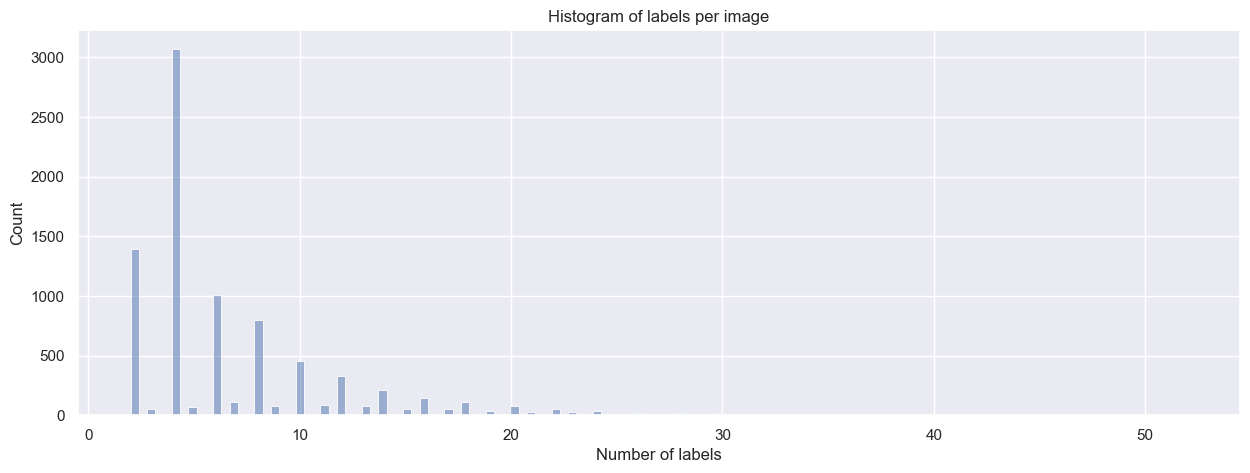

In [12]:
sns.set(rc={"figure.figsize": (15, 5)})
df_classes_count = df.groupby(["path"], as_index=False).agg(
    classes_count=("label_uid", lambda x: x.nunique())
)
sns.histplot(df_classes_count, legend=False).set(
    title="Histogram of labels per image", xlabel="Number of labels"
)
df_classes_count["classes_count"].sort_values().unique()

The image containing 52 tracks is rs00990.jpg.
Below we show the scence.

In [13]:
df_classes_count[df_classes_count["classes_count"] == 52].path.values[0]

'rs00990.jpg'

In [14]:
file = df[
    df["path"]
    == df_classes_count[df_classes_count["classes_count"] == 52].path.values[0]
].path.unique()[0]
path = f"./orig_data/rs19_val/jpgs/rs19_val/"

rs00990.jpg


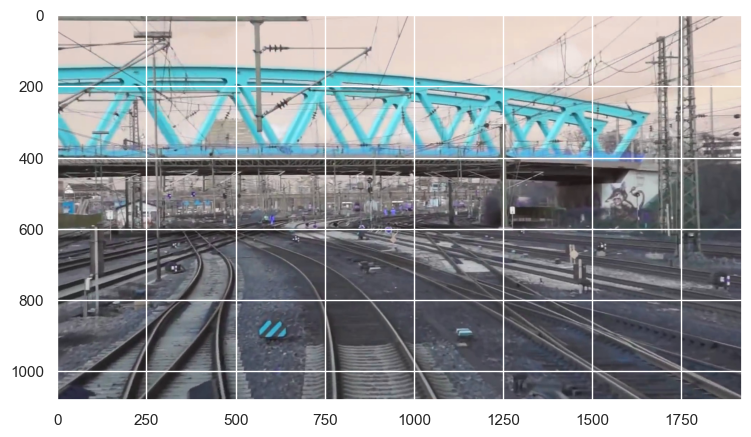

In [15]:
print_image(df, path=path, file=file)

### Some examples

Next, we visualize some images and plot the labels in red in order to get a feeling for the dataset.
There is a wide range of images, e.g. different locations, weather and light conditions.

rs08480.jpg


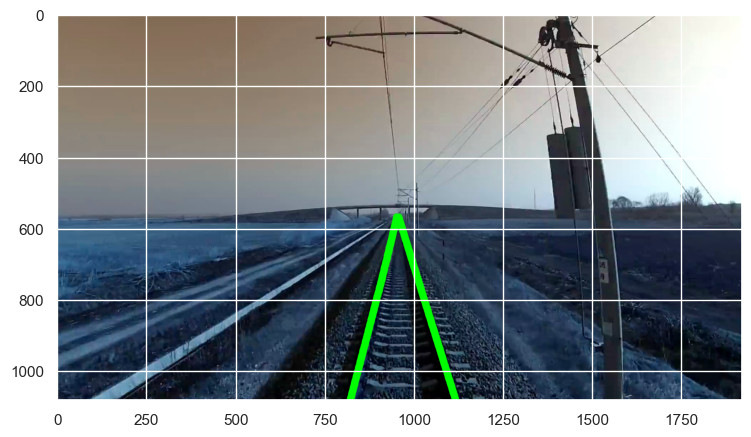

rs08480.jpg


In [16]:
file = df.path.unique()[-20]
print_image(df, path=path, file=file, include_polyline=True)
print(file)

rs00010.jpg


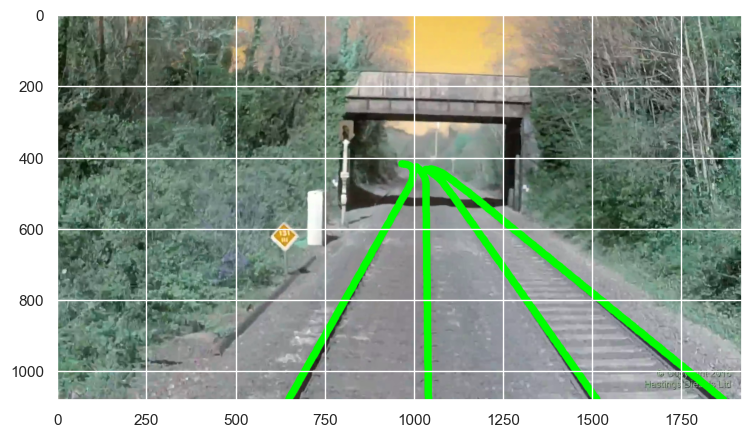

rs00010.jpg


In [17]:
file = df.path.unique()[10]
print_image(df, path=path, file=file, include_polyline=True)
print(file)

rs00022.jpg


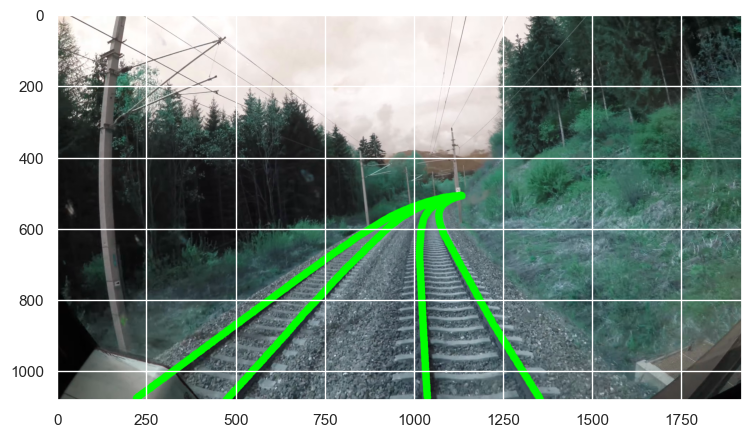

rs00022.jpg


In [18]:
file = df.path.unique()[22]
print_image(df, path=path, file=file, include_polyline=True)
print(file)

### Analyze the brightness of the images

As observed above, the images vary widely in their brightness. It is to be expected that the brightness plays an important role in achieving a high accuracy when predicting tracks. Therefore, we analyze the brightness of the images per sensor.

In [19]:
%%time
## calculating the birghtness for each image takes around 30min. Therefore, we load the data from the hard drive if available.
files = glob('./dataframe_dumps/railsem_brightness_dump_*')
print(files)
if len(files) > 0:
    df_temp = pd.read_csv(max(files, key=os.path.getmtime))
else:
    df_temp = df[["path"]].drop_duplicates()
    df_temp["brightness"] = df_temp.apply(lambda x: calculate_brightness(f"./orig_data/rs19_val/jpgs/rs19_val//{x.path}"), axis=1)
    brightness_dump = f"./dataframe_dumps/railsem_brightness_dump_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.csv"
    df_temp.to_csv(brightness_dump, index=False)

['./dataframe_dumps\\railsem_brightness_dump_10-20-2023_16-25-38.csv']
CPU times: total: 0 ns
Wall time: 12.1 ms


We can see that the dataset features very dark images (brightness close to 0) and very bright images (brightness close to the maximum of 255).


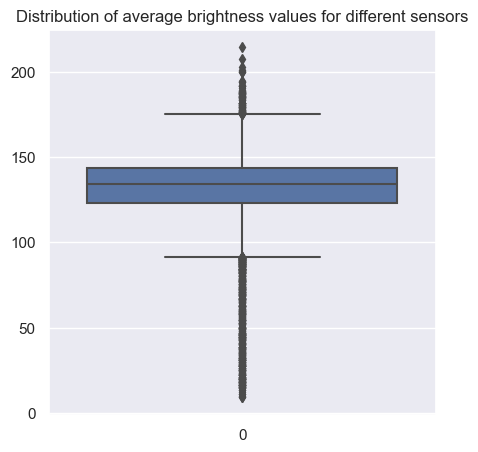

In [20]:
sns.set(rc={"figure.figsize": (5, 5)})
_ = sns.boxplot(
    df_temp["brightness"],
).set(title="Distribution of average brightness values for different sensors")

### Images as part of videos

Compared to the Digitale Schiene/DB dataset we see a large variety of different images (including images from trams).

In [21]:
li = EasyImageList.from_folder("./orig_data/rs19_val/jpgs/rs19_val/")
li.html(size=200, sample=20)

In [35]:
df.to_json(
    f"./dataframe_dumps/df_railsem_eda_{datetime.now().strftime('%m-%d-%Y_%H-%M-%S')}.json"
)